In [1]:
import functools
from dynesty import NestedSampler
from dynesty import utils as dyfunc
import numpy as np


def prior_transform(u):
    return u

def integrate_likelihood(x, *args, logp): #x = None, y = None
    if len(args) != 0 or type(x).__name__ == 'float': #and len(x) != 0:        
        X = np.array([x, *args])
        X = np.expand_dims(X, -2)
        #output = np.exp(logp(X))[0]
        output = logp(X)
    elif len(args) == 0: #and len([x]) != 0:
        x = np.array(x)
        #print(x)
        output = logp(x).squeeze(-1)
    else:
        print("Number of args: ", len(args))
        print("Args: ", args)
    return output

def dynesty_true_integral(bounds, ndim, dlogz, logp, prior_fac):
    ### Dynesty ###
    ptform_kwargs={'bounds': bounds}
    integrate_likelihood_dy = functools.partial(integrate_likelihood, logp=logp)
    sampler = NestedSampler(integrate_likelihood_dy, prior_transform, ndim=ndim, 
                       blob=False )#, pool=pool, queue_size=nthreads)
    sampler.run_nested(print_progress=True, dlogz=dlogz)
    
    res = sampler.results
    print(len(res.ncall))
    logz_dy = res.logz[-1] + 2*prior_fac #ln(z_dynesty) + ln(prior_fac) = z_dynesty*prior_fac = Evidence -> Why do we have to do 2xprior_fac?
    logzerr_dy = res.logzerr[-1]
    computed_integrals = dyfunc.compute_integrals(res.logl, res.logvol)
    #log.info(computed_integrals[1][-1], computed_integrals[2][-1])
    print(f"Logz from Dynesty = {logz_dy} +- {logzerr_dy} with {len(res.ncall)} samples")
    return logz_dy, logzerr_dy, len(res.ncall)

In [5]:
ndim = 5
def gaussian(X):
    # X is a N x DIM shaped tensor, output is N tensor
    mean = np.array(0.5) #len(param_list)*
    sigma = np.array(0.1) #len(param_list)*
    return np.expand_dims((-0.5*np.sum((X-mean)**2/sigma**2, axis=-1, keepdims=False)), -1)
for i in range(1, 31):
    print(i)
    dynesty_true_integral([0, 1]*i, i, 0.1, gaussian, 0)

1


1884it [00:00, 4085.65it/s, +500 | bound: 1 | nc: 1 | ncall: 18761 | eff(%): 13.055 | loglstar:   -inf < -0.000 <    inf | logz: -1.411 +/-  0.036 | dlogz:  0.000 >  0.100]


2384
Logz from Dynesty = -1.411399163372794 +- 0.056660544692869866 with 2384 samples
2


2555it [00:00, 5333.78it/s, +500 | bound: 2 | nc: 1 | ncall: 19664 | eff(%): 15.941 | loglstar:   -inf < -0.000 <    inf | logz: -2.756 +/-  0.059 | dlogz:  0.000 >  0.100]


3055
Logz from Dynesty = -2.7557303790503123 +- 0.07904273037153446 with 3055 samples
3


3295it [00:00, 5533.71it/s, +500 | bound: 4 | nc: 1 | ncall: 21966 | eff(%): 17.679 | loglstar:   -inf < -0.006 <    inf | logz: -4.250 +/-  0.077 | dlogz:  0.000 >  0.100]


3795
Logz from Dynesty = -4.249796252958203 +- 0.0973783347667058 with 3795 samples
4


3858it [00:00, 5754.81it/s, +500 | bound: 6 | nc: 1 | ncall: 22208 | eff(%): 20.076 | loglstar:   -inf < -0.033 <    inf | logz: -5.410 +/-  0.088 | dlogz:  0.000 >  0.100]


4358
Logz from Dynesty = -5.409602430977576 +- 0.10930272474590148 with 4358 samples
5


4543it [00:00, 5821.32it/s, +500 | bound: 8 | nc: 1 | ncall: 24886 | eff(%): 20.680 | loglstar:   -inf < -0.054 <    inf | logz: -6.810 +/-  0.099 | dlogz:  0.000 >  0.100]


5043
Logz from Dynesty = -6.809513236619844 +- 0.12119124503330904 with 5043 samples
6


5233it [00:00, 5918.87it/s, +500 | bound: 11 | nc: 1 | ncall: 26275 | eff(%): 22.242 | loglstar:   -inf < -0.142 <    inf | logz: -8.285 +/-  0.109 | dlogz:  0.000 >  0.100]


5733
Logz from Dynesty = -8.285029611297572 +- 0.1309959386248049 with 5733 samples
7


5859it [00:01, 5609.66it/s, +500 | bound: 15 | nc: 1 | ncall: 28433 | eff(%): 22.765 | loglstar:   -inf < -0.215 <    inf | logz: -9.613 +/-  0.118 | dlogz:  0.000 >  0.100]


6359
Logz from Dynesty = -9.612691807951727 +- 0.14111495780338384 with 6359 samples
8


6537it [00:01, 5708.79it/s, +500 | bound: 18 | nc: 1 | ncall: 31012 | eff(%): 23.063 | loglstar:   -inf < -0.179 <    inf | logz: -10.942 +/-  0.126 | dlogz:  0.000 >  0.100]


7037
Logz from Dynesty = -10.941802242722694 +- 0.14776140872172275 with 7037 samples
9


7131it [00:01, 5293.48it/s, +500 | bound: 22 | nc: 1 | ncall: 34456 | eff(%): 22.473 | loglstar:   -inf < -0.269 <    inf | logz: -12.224 +/-  0.133 | dlogz:  0.000 >  0.100]


7631
Logz from Dynesty = -12.22445105478488 +- 0.15465250619211215 with 7631 samples
10


7874it [00:03, 2119.09it/s, +500 | bound: 84 | nc: 1 | ncall: 202969 | eff(%):  4.136 | loglstar:   -inf < -0.501 <    inf | logz: -13.942 +/-  0.141 | dlogz:  0.000 >  0.100]


8374
Logz from Dynesty = -13.94199612189702 +- 0.16430228422535442 with 8374 samples
11


8390it [00:04, 2014.37it/s, +500 | bound: 90 | nc: 1 | ncall: 224644 | eff(%):  3.966 | loglstar:   -inf < -0.718 <    inf | logz: -15.193 +/-  0.147 | dlogz:  0.000 >  0.100]


8890
Logz from Dynesty = -15.19338057800269 +- 0.17055062968592546 with 8890 samples
12


8994it [00:04, 2004.26it/s, +500 | bound: 98 | nc: 1 | ncall: 250497 | eff(%):  3.798 | loglstar:   -inf < -0.678 <    inf | logz: -16.363 +/-  0.153 | dlogz:  0.000 >  0.100]


9494
Logz from Dynesty = -16.362927581063882 +- 0.17680994885433116 with 9494 samples
13


9615it [00:04, 1970.74it/s, +500 | bound: 105 | nc: 1 | ncall: 276779 | eff(%):  3.661 | loglstar:   -inf < -1.099 <    inf | logz: -18.023 +/-  0.161 | dlogz:  0.000 >  0.100]


10115
Logz from Dynesty = -18.02271369410523 +- 0.18697117133771493 with 10115 samples
14


10259it [00:05, 1952.31it/s, +500 | bound: 113 | nc: 1 | ncall: 305518 | eff(%):  3.527 | loglstar:   -inf < -0.959 <    inf | logz: -19.177 +/-  0.166 | dlogz:  0.000 >  0.100]


10759
Logz from Dynesty = -19.177152898561012 +- 0.18958139132012478 with 10759 samples
15


11033it [00:05, 1874.78it/s, +500 | bound: 125 | nc: 1 | ncall: 342744 | eff(%):  3.370 | loglstar:   -inf < -0.975 <    inf | logz: -20.744 +/-  0.171 | dlogz:  0.000 >  0.100]


11533
Logz from Dynesty = -20.743790221281884 +- 0.19133087995363735 with 11533 samples
16


11491it [00:06, 1847.80it/s, +500 | bound: 130 | nc: 1 | ncall: 367356 | eff(%):  3.269 | loglstar:   -inf < -1.523 <    inf | logz: -22.205 +/-  0.178 | dlogz:  0.000 >  0.100]


11991
Logz from Dynesty = -22.20525945061323 +- 0.2019719725124271 with 11991 samples
17


11886it [00:06, 1849.38it/s, +500 | bound: 134 | nc: 1 | ncall: 390556 | eff(%):  3.175 | loglstar:   -inf < -2.056 <    inf | logz: -23.525 +/-  0.182 | dlogz:  0.000 >  0.100]


12386
Logz from Dynesty = -23.525450838101516 +- 0.20840794391449113 with 12386 samples
18


12615it [00:06, 1808.95it/s, +500 | bound: 145 | nc: 1 | ncall: 428889 | eff(%):  3.061 | loglstar:   -inf < -2.326 <    inf | logz: -25.253 +/-  0.189 | dlogz:  0.000 >  0.100]


13115
Logz from Dynesty = -25.252882053835716 +- 0.2147673679621434 with 13115 samples
19


13287it [00:07, 1753.23it/s, +500 | bound: 156 | nc: 1 | ncall: 467705 | eff(%):  2.951 | loglstar:   -inf < -1.650 <    inf | logz: -25.929 +/-  0.189 | dlogz:  0.000 >  0.100]


13787
Logz from Dynesty = -25.929431840117978 +- 0.20620314400899645 with 13787 samples
20


13957it [00:08, 1709.23it/s, +500 | bound: 164 | nc: 1 | ncall: 504972 | eff(%):  2.866 | loglstar:   -inf < -2.103 <    inf | logz: -27.720 +/-  0.196 | dlogz:  0.000 >  0.100]


14457
Logz from Dynesty = -27.71963658130063 +- 0.21793499095640864 with 14457 samples
21


14450it [00:17, 813.73it/s, +500 | bound: 67 | nc: 1 | ncall: 1615983 | eff(%):  0.925 | loglstar:   -inf < -2.259 <    inf | logz: -28.863 +/-  0.200 | dlogz:  0.000 >  0.100]


14950
Logz from Dynesty = -28.863351309066495 +- 0.22080935650488998 with 14950 samples
22


14757it [00:18, 792.28it/s, +500 | bound: 71 | nc: 1 | ncall: 1724315 | eff(%):  0.885 | loglstar:   -inf < -2.999 <    inf | logz: -30.214 +/-  0.203 | dlogz:  0.000 >  0.100]


15257
Logz from Dynesty = -30.213544538255718 +- 0.22496376246754707 with 15257 samples
23


15478it [00:20, 739.94it/s, +500 | bound: 76 | nc: 1 | ncall: 1895520 | eff(%):  0.843 | loglstar:   -inf < -2.901 <    inf | logz: -31.557 +/-  0.209 | dlogz:  0.000 >  0.100]


15978
Logz from Dynesty = -31.557222274260862 +- 0.2319001305075294 with 15978 samples
24


15733it [00:21, 729.90it/s, +500 | bound: 79 | nc: 1 | ncall: 1998843 | eff(%):  0.812 | loglstar:   -inf < -3.670 <    inf | logz: -32.831 +/-  0.214 | dlogz:  0.000 >  0.100]


16233
Logz from Dynesty = -32.831471777846446 +- 0.24210734221506203 with 16233 samples
25


16656it [00:24, 689.15it/s, +500 | bound: 81 | nc: 1 | ncall: 2214636 | eff(%):  0.775 | loglstar:   -inf < -3.467 <    inf | logz: -34.477 +/-  0.218 | dlogz:  0.000 >  0.100]


17156
Logz from Dynesty = -34.476839024457966 +- 0.2417175333215191 with 17156 samples
26


17087it [00:24, 685.59it/s, +500 | bound: 87 | nc: 1 | ncall: 2359607 | eff(%):  0.745 | loglstar:   -inf < -3.633 <    inf | logz: -35.506 +/-  0.221 | dlogz:  0.000 >  0.100]


17587
Logz from Dynesty = -35.505995467182935 +- 0.24506710619228386 with 17587 samples
27


17431it [00:26, 664.85it/s, +500 | bound: 88 | nc: 1 | ncall: 2469693 | eff(%):  0.726 | loglstar:   -inf < -4.364 <    inf | logz: -36.922 +/-  0.226 | dlogz:  0.000 >  0.100]


17931
Logz from Dynesty = -36.92161469421936 +- 0.2526471722749728 with 17931 samples
28


18230it [00:28, 630.85it/s, +500 | bound: 92 | nc: 1 | ncall: 2691800 | eff(%):  0.696 | loglstar:   -inf < -4.769 <    inf | logz: -38.924 +/-  0.233 | dlogz:  0.000 >  0.100]


18730
Logz from Dynesty = -38.9238457087405 +- 0.26246939753652454 with 18730 samples
29


18666it [00:30, 608.66it/s, +500 | bound: 96 | nc: 1 | ncall: 2852259 | eff(%):  0.672 | loglstar:   -inf < -4.839 <    inf | logz: -39.869 +/-  0.231 | dlogz:  0.000 >  0.100]


19166
Logz from Dynesty = -39.868844502875056 +- 0.252588093846613 with 19166 samples
30


18971it [00:33, 569.39it/s, +500 | bound: 100 | nc: 1 | ncall: 3002382 | eff(%):  0.649 | loglstar:   -inf < -5.648 <    inf | logz: -41.282 +/-  0.238 | dlogz:  0.000 >  0.100]

19471
Logz from Dynesty = -41.281536117303894 +- 0.2678628918955436 with 19471 samples


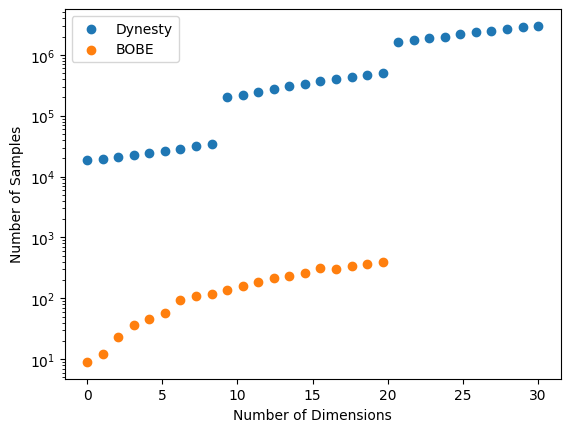

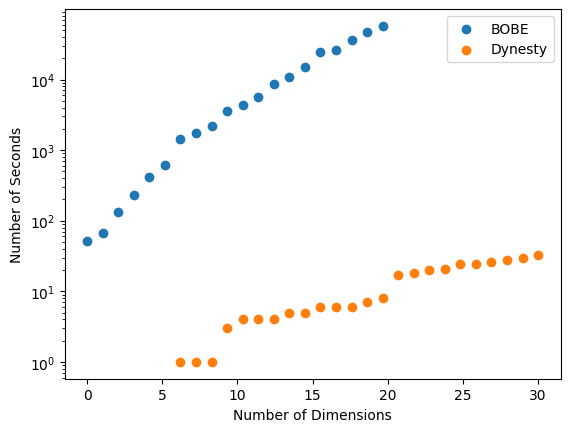

In [6]:
import matplotlib.pyplot as plt
import numpy as np
DySamples = [18967, 19805, 20806, 22626, 24220, 26606, 28723, 32048, 34956, 200489, 221377, 249393, 275343, 304664, 335873, 367928, 403719, 430882, 463838, 498671, 1621314, 1773526, 1891795, 2003966, 2170079, 2359607, 2469693, 2691800, 2852259, 3002382]
#BOBESamples = [17, 17, 28.667, 36.667, 55, 75.333, 107.667, 144.667, 187.333, 243, 304, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
BOBESamples = [9, 12, 23, 37, 46, 58, 95, 111, 117, 137, 158, 185, 218, 236, 258, 319, 298, 345, 369, 388, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
x = np.linspace(0, 30, 30)

plt.plot()
plt.scatter(x, DySamples, label="Dynesty")
plt.scatter(x, BOBESamples, label="BOBE")
plt.yscale('log')
plt.xlabel('Number of Dimensions')
plt.ylabel('Number of Samples')
plt.legend()
plt.show()



BOBETime = [52, 1*60+8, 2*60+11, 3*60+49, 6*60+54, 10*60 + 15, 24*60, 28*60 + 44, 37*60 + 3, 1*3600 + 26, 1*3600 + 13*60 + 5, 1*3600 + 35*60 + 39, 2*3600 + 25*60 + 26, 3*3600 + 54, 4*3600 + 7*60 + 13, 6*3600 +53*60 + 54, 7*3600 + 10*60 + 41, 9*3600 + 58*60 + 1, 12*3600 + 56*60 + 34, 15*3600 + 58*60 + 50, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
DyTime = [0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 4, 4, 4, 5, 5, 6, 6, 6, 7, 8, 17, 18, 20, 21, 24, 24, 26, 28, 30, 33]
x = np.linspace(0, 30, 30)

plt.plot()
plt.scatter(x, BOBETime, label="BOBE")
plt.scatter(x, DyTime, label="Dynesty")
plt.yscale('log')
plt.xlabel('Number of Dimensions')
plt.ylabel('Number of Seconds')
plt.legend()
plt.show()